# UCI time series examples

In [4]:
import multiprocessing as mp
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import sys
import warnings
import os
from random import randint
from scipy.ndimage.filters import uniform_filter1d
from numpy.random import normal
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_process import arma_generate_sample
#from statsmodels.tsa.arima_model import 

if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [5]:
os.getcwd()

'/Users/brunobarbarioli/Documents/Research/OTSS'

In [6]:
from algorithms.online_subsampler import *
from algorithms.analytics import *
from algorithms.breakpoint_detection import *
from algorithms.empirical_bernstein import *
from algorithms.uniform_subsampler import *
from algorithms.queries import *
from algorithms.size_optimizer import *

## Example 1 - UCI Household power consumption

https://archive.ics.uci.edu/ml/datasets/Individual+household+electric+power+consumption

In [8]:
path = '/Users/brunobarbarioli/Documents/Research/OTSS/datasets/household_power_consumption.txt'
data = pd.read_csv(path, sep = ';')

In [5]:
print(data.head(5))

         Date      Time Global_active_power Global_reactive_power  Voltage  \
0  16/12/2006  17:24:00               4.216                 0.418  234.840   
1  16/12/2006  17:25:00               5.360                 0.436  233.630   
2  16/12/2006  17:26:00               5.374                 0.498  233.290   
3  16/12/2006  17:27:00               5.388                 0.502  233.740   
4  16/12/2006  17:28:00               3.666                 0.528  235.680   

  Global_intensity Sub_metering_1 Sub_metering_2  Sub_metering_3  
0           18.400          0.000          1.000            17.0  
1           23.000          0.000          1.000            16.0  
2           23.000          0.000          2.000            17.0  
3           23.000          0.000          1.000            17.0  
4           15.800          0.000          1.000            17.0  


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    object 
 3   Global_reactive_power  object 
 4   Voltage                object 
 5   Global_intensity       object 
 6   Sub_metering_1         object 
 7   Sub_metering_2         object 
 8   Sub_metering_3         float64
dtypes: float64(1), object(8)
memory usage: 142.5+ MB


In [7]:
data = data[data.Sub_metering_1 != '?']
data = data[data.Sub_metering_2 != '?']
data = data[data.Sub_metering_3 != '?']

In [8]:
data.index = pd.to_datetime(data['Date'] +' '+ data['Time'])
data_clean = data.drop(columns = ['Date', 'Time'])

In [9]:
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2049280 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    object 
 1   Global_reactive_power  object 
 2   Voltage                object 
 3   Global_intensity       object 
 4   Sub_metering_1         object 
 5   Sub_metering_2         object 
 6   Sub_metering_3         float64
dtypes: float64(1), object(6)
memory usage: 125.1+ MB


### Sub metering 3

In [27]:
x = data_clean['Sub_metering_3']
x = x['2007-11':'2008-03']
#print(len(x))

218872


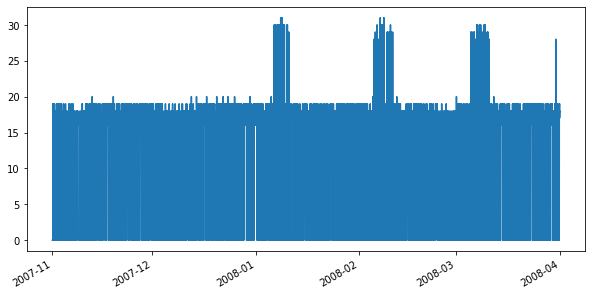

In [14]:
plt.figure(figsize=(15,5))
x.plot()

breakpoint started
subsampler started


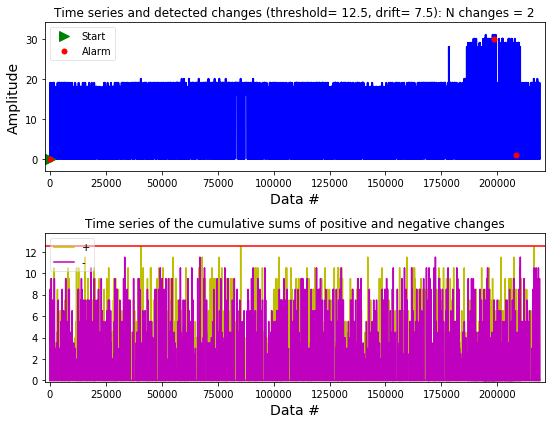

Interval size:  198523
Relative sample size:  0.35 %
----*----
Interval size:  9583
Relative sample size:  17.74 %
----*----
Interval size:  10766
Relative sample size:  15.33 %
----*----
Done


In [15]:
# Online subsampler

queue = mp.Queue()
return_queue = mp.Queue()
index_queue = mp.Queue()
p1 = mp.Process(target = detection, args = (x, queue, 12.5, 7.5, False, True))
p2 = mp.Process(target = online_subsampler, args = (0.15,0.01,20,50,x, queue, return_queue,index_queue, 1000))

p1.start()
p2.start()

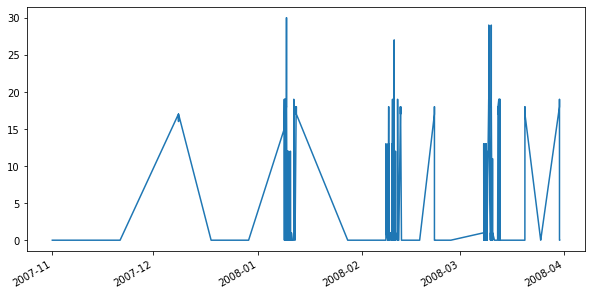

In [16]:
online_subsample = retrieve_data(return_queue)
online_subsample.plot(figsize=(10, 5))

In [17]:
#Baseline Subsamples
online_subsample_size = len(online_subsample)
uniform_sample, eb_sample = size_optimizer(x, online_subsample_size, 10, error = 0.25)

In [32]:
#Comparing subsample sizes
print('Online subsample size: ', online_subsample_size)
print('EB subsample size: ',len(eb_sample))
print('Uniform subsample size: ',len(uniform_sample))

Online subsample size:  34118
EB subsample size:  36788
Uniform subsample size:  34993


In [22]:
online_subsample

2007-11-01 00:00:00    0.0
2007-12-29 06:01:00    0.0
2007-12-29 06:02:00    0.0
2007-12-29 06:03:00    0.0
2007-12-29 06:04:00    0.0
                      ... 
2008-02-10 13:32:00    0.0
2008-02-10 13:33:00    1.0
2008-02-10 13:34:00    1.0
2008-02-10 13:35:00    0.0
2008-03-12 23:59:00    0.0
Name: Sub_metering_3, Length: 7036, dtype: float64

In [23]:
#upscaled subsamples
online_sample_upscaled = online_subsample.resample('T').mean()
eb_sample_upscaled = eb_sample.resample('T').mean()
uniform_sample_upscaled = uniform_sample.resample('T').mean()

In [24]:
#interpolation querry
#10
print('Interpolation for 57th value: \n')
print('Real value: ', x[57])
print('Empirical Bernstein: ', interpolation_query(eb_sample_upscaled, 57, method = 'linear'))
print('Uniform sampler: ', interpolation_query(uniform_sample_upscaled, 57, method = 'linear'))
print('Online Sampler:', interpolation_query(online_sample_upscaled, 57, method = 'linear'))
print('------------\n')

#17400
print('Interpolation for 17400 value: \n')
print('Real value: ', x[17401])
print('Empirical Bernstein: ', interpolation_query(eb_sample_upscaled, 17401, method = 'linear'))
print('Uniform sampler: ', interpolation_query(uniform_sample_upscaled, 17401, method = 'linear'))
print('Online Sampler:', interpolation_query(online_sample_upscaled, 17401, method = 'linear'))
print('------------\n')

#1003

print('Interpolation for 1003 value: \n')
print('Real value: ', x[1003])
print('Empirical Bernstein: ', interpolation_query(eb_sample_upscaled, 1003, method = 'linear'))
print('Uniform sampler: ', interpolation_query(uniform_sample_upscaled, 1003, method = 'linear'))
print('Online Sampler:', interpolation_query(online_sample_upscaled, 1003, method = 'linear'))
print('------------\n')

#77802

print('Interpolation for 77802 value: \n')
print('Real value: ', x[77802])
print('Empirical Bernstein: ', interpolation_query(eb_sample_upscaled, 77802, method = 'linear'))
print('Uniform sampler: ', interpolation_query(uniform_sample_upscaled, 77802, method = 'linear'))
print('Online Sampler:', interpolation_query(online_sample_upscaled, 77802, method = 'linear'))
print('------------\n')

Interpolation for 57th value: 

Real value:  0.0
Empirical Bernstein:  0.0
Uniform sampler:  0.0
Online Sampler: 0.0
------------

Interpolation for 17400 value: 

Real value:  0.0
Empirical Bernstein:  0.0
Uniform sampler:  0.0
Online Sampler: 0.0
------------

Interpolation for 1003 value: 

Real value:  17.0
Empirical Bernstein:  17.0
Uniform sampler:  17.35483870967742
Online Sampler: 0.0
------------

Interpolation for 77802 value: 

Real value:  0.0
Empirical Bernstein:  0.0
Uniform sampler:  0.0
Online Sampler: 0.0
------------



In [26]:
#Comparing upsample sizes
print('Online subsample size: ', len(online_sample_upscaled))
print('EB subsample size: ',len(eb_sample_upscaled))
print('Uniform subsample size: ',len(uniform_sample_upscaled))

Online subsample size:  216906
EB subsample size:  218869
Uniform subsample size:  218875


In [ ]:
# Distance metrics for linear interpolation

print('Euclidean distance: \n')
print('Empirical Bernstein: ', interpolation_distance(x, eb_sample_upscaled))
print('Uniform: ', interpolation_distance(x, uniform_sample_upscaled))
print('Online Sampler: \n', interpolation_distance(x, online_sample_upscaled))
print('------------ \n')

print('DTW distance: \n')
print('Empirical Bernstein: ', interpolation_distance(x, eb_sample_upscaled, distance = 'dtw'))
print('Uniform: ', interpolation_distance(x, uniform_sample_upscaled, distance = 'dtw'))
print('Online Sampler: \n', interpolation_distance(x, online_sample_upscaled, distance = 'dtw'))
print('------------\n')

In [28]:
# Autocorrelation

print('Autocorrelation: \n')
print('Original time series: ')
correlation_query(x, number_of_lags = 2, print_lags = True, plot = False)
print('Empirical Bernstein: ')
correlation_query(eb_sample, number_of_lags = 2, print_lags = True, plot = False)
print('Uniform: ' )
correlation_query(uniform_sample, number_of_lags = 2, print_lags = True, plot = False)
print('Online Sampler:', )
correlation_query(online_subsample, number_of_lags = 2, print_lags = True, plot = False)
print('------------ \n')

Autocorrelation: 

Original time series: 
lag 0:  0.9894896801257027
lag 1:  0.9769372720303136
Empirical Bernstein: 
lag 0:  -0.006931661234351984
lag 1:  -0.028481259439640912
Uniform: 
lag 0:  0.6749131636116116
lag 1:  0.4810231933083478
Online Sampler:
lag 0:  0.9512558566406686
lag 1:  0.9001251456136088
------------ 



In [30]:
# Distance metrics for autocorrelation

print('Euclidean distance of all autocorrelation lags: \n')
print('Empirical Bernstein: ', correlation_distance(x, eb_sample, number_of_lags = 2, print_lags = False, plot = False))
print('Uniform: ', correlation_distance(x, uniform_sample, number_of_lags = 2, print_lags = False, plot = False))
print('Online Sampler: \n', correlation_distance(x, online_subsample, number_of_lags = 2, print_lags = False, plot = False))
print('------------ \n')

Euclidean distance of all autocorrelation lags: 

Empirical Bernstein:  1.41552884567605
Uniform:  0.5872726438518964
Online Sampler: 
 0.08580167843894769
------------ 



### Voltage

In [31]:
y = data_clean['Voltage']
y = y.astype('float')
y = y['2007-01':'2008-01']

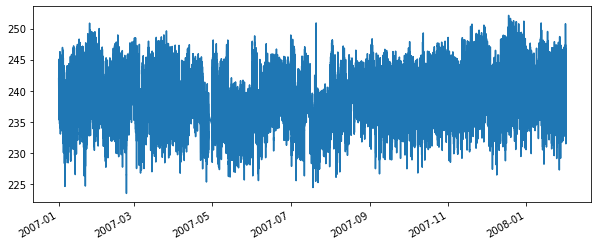

In [32]:
plt.figure(figsize=(10,4))
y.plot()

breakpoint started
subsampler started
Interval size:  54556
Relative sample size:  0.18 %
----*----
Interval size:  71599
Relative sample size:  0.14 %
----*----
Interval size:  77867
Relative sample size:  0.13 %
----*----
Interval size:  74791
Relative sample size:  0.13 %
----*----
Interval size:  6166
Relative sample size:  1.62 %
----*----
Interval size:  545
Relative sample size:  100%
----*----
Interval size:  16346
Relative sample size:  0.61 %
----*----
Interval size:  50284
Relative sample size:  0.2 %
----*----
Interval size:  89696
Relative sample size:  0.11 %
----*----
Interval size:  279
Relative sample size:  100%
----*----
Interval size:  120560
Relative sample size:  0.08 %
----*----
Interval size:  3619
Relative sample size:  2.76 %
----*----
Done


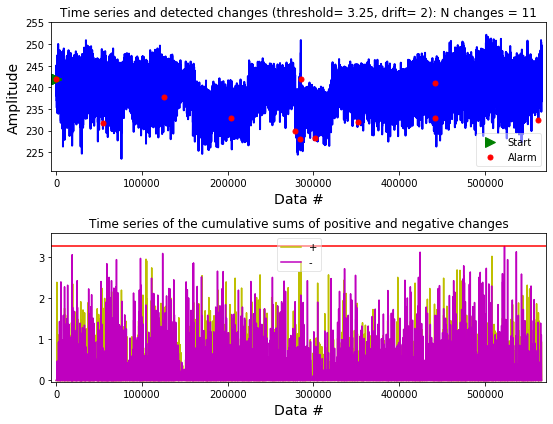

In [39]:
# Online subsampler

queue = mp.Queue()
return_queue = mp.Queue()
index_queue = mp.Queue()
p1 = mp.Process(target = detection, args = (y, queue, 3.25, 2, False, True))
p2 = mp.Process(target = online_subsampler, args = (0.15,0.01,20,50,y, queue, return_queue,index_queue, 1000))

p1.start()
p2.start()

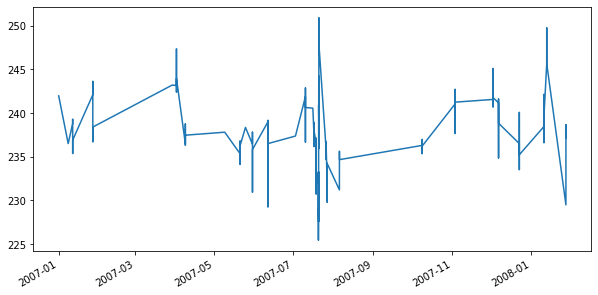

In [40]:
online_subsample = retrieve_data(return_queue)
online_subsample.plot(figsize=(10, 5))

In [41]:
#Baseline Subsamples
online_subsample_size = len(online_subsample)
uniform_sample, eb_sample = size_optimizer(y, online_subsample_size, 10, error = 0.25)

In [42]:
#Comparing subsample sizes
print('Online subsample size: ', online_subsample_size)
print('EB subsample size: ',len(eb_sample))
print('Uniform subsample size: ',len(uniform_sample))

Online subsample size:  6739
EB subsample size:  6516
Uniform subsample size:  6842


In [43]:
#upscaled subsamples
online_sample_upscaled = online_subsample.resample('T').mean()
eb_sample_upscaled = eb_sample.resample('T').mean()
uniform_sample_upscaled = uniform_sample.resample('T').mean()

In [ ]:
#interpolation querry
#10
print('Interpolation for 57th value: \n')
print('Real value: ', x[57])
print('Empirical Bernstein: ', interpolation_query(eb_sample_upscaled, 57, method = 'linear'))
print('Uniform sampler: ', interpolation_query(uniform_sample_upscaled, 57, method = 'linear'))
print('Online Sampler:', interpolation_query(online_sample_upscaled, 57, method = 'linear'))
print('------------\n')

#17400
print('Interpolation for 17400 value: \n')
print('Real value: ', x[17401])
print('Empirical Bernstein: ', interpolation_query(eb_sample_upscaled, 17401, method = 'linear'))
print('Uniform sampler: ', interpolation_query(uniform_sample_upscaled, 17401, method = 'linear'))
print('Online Sampler:', interpolation_query(online_sample_upscaled, 17401, method = 'linear'))
print('------------\n')

#1003

print('Interpolation for 1003 value: \n')
print('Real value: ', x[1003])
print('Empirical Bernstein: ', interpolation_query(eb_sample_upscaled, 1003, method = 'linear'))
print('Uniform sampler: ', interpolation_query(uniform_sample_upscaled, 1003, method = 'linear'))
print('Online Sampler:', interpolation_query(online_sample_upscaled, 1003, method = 'linear'))
print('------------\n')

#77802

print('Interpolation for 77802 value: \n')
print('Real value: ', x[77802])
print('Empirical Bernstein: ', interpolation_query(eb_sample_upscaled, 77802, method = 'linear'))
print('Uniform sampler: ', interpolation_query(uniform_sample_upscaled, 77802, method = 'linear'))
print('Online Sampler:', interpolation_query(online_sample_upscaled, 77802, method = 'linear'))
print('------------\n')

In [ ]:
# Distance metrics for linear interpolation

print('Euclidean distance: \n')
print('Empirical Bernstein: ', interpolation_distance(x, eb_sample_upscaled))
print('Uniform: ', interpolation_distance(x, uniform_sample_upscaled))
print('Online Sampler: \n', interpolation_distance(x, online_sample_upscaled))
print('------------ \n')

print('DTW distance: \n')
print('Empirical Bernstein: ', interpolation_distance(x, eb_sample_upscaled, distance = 'dtw'))
print('Uniform: ', interpolation_distance(x, uniform_sample_upscaled, distance = 'dtw'))
print('Online Sampler: \n', interpolation_distance(x, online_sample_upscaled, distance = 'dtw'))
print('------------\n')

In [45]:
# Autocorrelation

print('Autocorrelation: \n')
print('Original time series: ')
correlation_query(x, number_of_lags = 2, print_lags = True, plot = False)
print('Empirical Bernstein: ')
correlation_query(eb_sample, number_of_lags = 2, print_lags = True, plot = False)
print('Uniform: ' )
correlation_query(uniform_sample, number_of_lags = 2, print_lags = True, plot = False)
print('Online Sampler:', )
correlation_query(online_subsample, number_of_lags = 2, print_lags = True, plot = False)
print('------------ \n')

Autocorrelation: 

Original time series: 
lag 0:  0.9894896801257027
lag 1:  0.9769372720303136
Empirical Bernstein: 
lag 0:  0.0062355135611442
lag 1:  0.022912486359009696
Uniform: 
lag 0:  0.6618195820573486
lag 1:  0.47344988270203403
Online Sampler:
lag 0:  0.9713867432624731
lag 1:  0.9482429431637367
------------ 



In [46]:
# Distance metrics for autocorrelation

print('Euclidean distance of all autocorrelation lags: \n')
print('Empirical Bernstein: ', correlation_distance(y, eb_sample, number_of_lags = 2, print_lags = False, plot = False))
print('Uniform: ', correlation_distance(y, uniform_sample, number_of_lags = 2, print_lags = False, plot = False))
print('Online Sampler: \n', correlation_distance(y, online_subsample, number_of_lags = 2, print_lags = False, plot = False))
print('------------ \n')

Euclidean distance of all autocorrelation lags: 

Empirical Bernstein:  1.3700189953944952
Uniform:  0.6007222689236111
Online Sampler: 
 0.03392758217405631
------------ 



### Global active power

In [47]:
z = data_clean['Global_active_power']
z = z.astype('float')
z = z['2007-01':'2008-01']

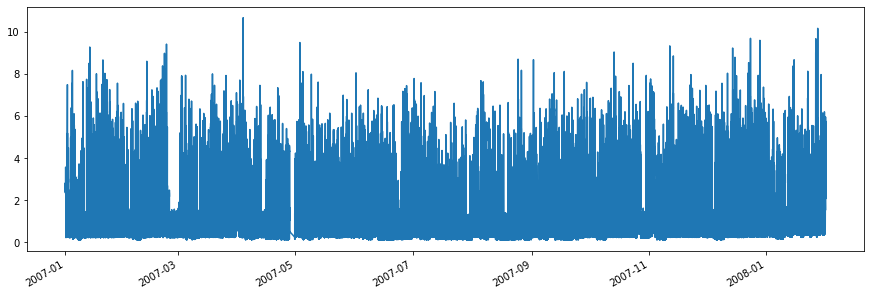

In [48]:
plt.figure(figsize=(15,5))
z.plot()

breakpoint started
subsampler started
Interval size:  19235
Relative sample size:  3.12 %
----*----
Interval size:  79142
Relative sample size:  1.33 %
----*----
Interval size:  38829
Relative sample size:  3.22 %
----*----
Interval size:  22346
Relative sample size:  6.49 %
----*----
Interval size:  714
Relative sample size:  100%
----*----
Interval size:  43756
Relative sample size:  3.77 %
----*----
Interval size:  4770
Relative sample size:  100%
----*----
Interval size:  108976
Relative sample size:  1.65 %
----*----
Interval size:  34386
Relative sample size:  5.53 %
----*----
Interval size:  110886
Relative sample size:  1.67 %
----*----
Interval size:  8123
Relative sample size:  100%
----*----
Interval size:  49585
Relative sample size:  3.73 %
----*----
Interval size:  2361
Relative sample size:  100%
----*----
Interval size:  13832
Relative sample size:  100%
----*----
Interval size:  29367
Relative sample size:  6.13 %
----*----
Done


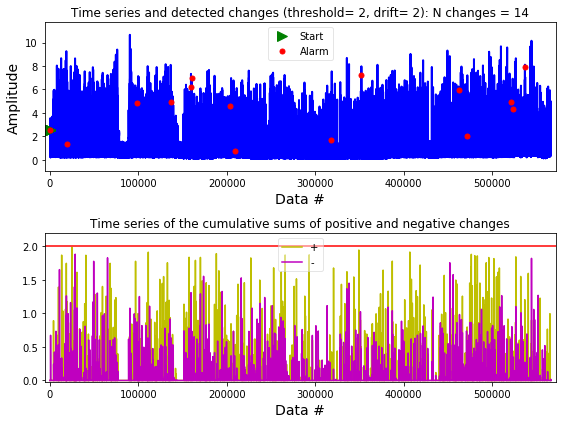

In [55]:
# Online subsampler

queue = mp.Queue()
return_queue = mp.Queue()
index_queue = mp.Queue()
p1 = mp.Process(target = detection, args = (z, queue, 2, 2, False, True))
p2 = mp.Process(target = online_subsampler, args = (0.15,0.01,10,50,z, queue, return_queue,index_queue, 1000))

p1.start()
p2.start()

In [58]:
#Baseline Subsamples
online_subsample_size = len(online_subsample)
uniform_sample, eb_sample = size_optimizer(z, online_subsample_size, 10, error = 0.25)

In [59]:
#Comparing subsample sizes
print('Online subsample size: ', online_subsample_size)
print('EB subsample size: ',len(eb_sample))
print('Uniform subsample size: ',len(uniform_sample))

Online subsample size:  6739
EB subsample size:  5609
Uniform subsample size:  6744


In [ ]:
#upscaled subsamples
online_sample_upscaled = online_subsample.resample('T').mean()
eb_sample_upscaled = eb_sample.resample('T').mean()
uniform_sample_upscaled = uniform_sample.resample('T').mean()

In [ ]:
#interpolation querry
#10
print('Interpolation for 57th value: \n')
print('Real value: ', x[57])
print('Empirical Bernstein: ', interpolation_query(eb_sample_upscaled, 57, method = 'linear'))
print('Uniform sampler: ', interpolation_query(uniform_sample_upscaled, 57, method = 'linear'))
print('Online Sampler:', interpolation_query(online_sample_upscaled, 57, method = 'linear'))
print('------------\n')

#17400
print('Interpolation for 17400 value: \n')
print('Real value: ', x[17401])
print('Empirical Bernstein: ', interpolation_query(eb_sample_upscaled, 17401, method = 'linear'))
print('Uniform sampler: ', interpolation_query(uniform_sample_upscaled, 17401, method = 'linear'))
print('Online Sampler:', interpolation_query(online_sample_upscaled, 17401, method = 'linear'))
print('------------\n')

#1003

print('Interpolation for 1003 value: \n')
print('Real value: ', x[1003])
print('Empirical Bernstein: ', interpolation_query(eb_sample_upscaled, 1003, method = 'linear'))
print('Uniform sampler: ', interpolation_query(uniform_sample_upscaled, 1003, method = 'linear'))
print('Online Sampler:', interpolation_query(online_sample_upscaled, 1003, method = 'linear'))
print('------------\n')

#77802

print('Interpolation for 77802 value: \n')
print('Real value: ', x[77802])
print('Empirical Bernstein: ', interpolation_query(eb_sample_upscaled, 77802, method = 'linear'))
print('Uniform sampler: ', interpolation_query(uniform_sample_upscaled, 77802, method = 'linear'))
print('Online Sampler:', interpolation_query(online_sample_upscaled, 77802, method = 'linear'))
print('------------\n')

In [ ]:
# Distance metrics for linear interpolation

print('Euclidean distance: \n')
print('Empirical Bernstein: ', interpolation_distance(z, eb_sample_upscaled))
print('Uniform: ', interpolation_distance(z, uniform_sample_upscaled))
print('Online Sampler: \n', interpolation_distance(z, online_sample_upscaled))
print('------------ \n')

print('DTW distance: \n')
print('Empirical Bernstein: ', interpolation_distance(z, eb_sample_upscaled, distance = 'dtw'))
print('Uniform: ', interpolation_distance(z, uniform_sample_upscaled, distance = 'dtw'))
print('Online Sampler: \n', interpolation_distance(z, online_sample_upscaled, distance = 'dtw'))
print('------------\n')

In [60]:
# Autocorrelation

print('Autocorrelation: \n')
print('Original time series: ')
correlation_query(z, number_of_lags = 2, print_lags = True, plot = False)
print('Empirical Bernstein: ')
correlation_query(eb_sample, number_of_lags = 2, print_lags = True, plot = False)
print('Uniform: ' )
correlation_query(uniform_sample, number_of_lags = 2, print_lags = True, plot = False)
print('Online Sampler:', )
correlation_query(online_subsample, number_of_lags = 2, print_lags = True, plot = False)
print('------------ \n')

Autocorrelation: 

Original time series: 
lag 0:  0.9677428484548084
lag 1:  0.9335338130069806
Empirical Bernstein: 
lag 0:  0.01601215304764821
lag 1:  0.004989677775406467
Uniform: 
lag 0:  0.46029938155301486
lag 1:  0.22838769613882703
Online Sampler:
lag 0:  0.9713867432624731
lag 1:  0.9482429431637367
------------ 



In [61]:
# Distance metrics for autocorrelation

print('Euclidean distance of all autocorrelation lags: \n')
print('Empirical Bernstein: ', correlation_distance(z, eb_sample, number_of_lags = 2, print_lags = False, plot = False))
print('Uniform: ', correlation_distance(z, uniform_sample, number_of_lags = 2, print_lags = False, plot = False))
print('Online Sampler: \n', correlation_distance(z, online_subsample, number_of_lags = 2, print_lags = False, plot = False))
print('------------ \n')

Euclidean distance of all autocorrelation lags: 

Empirical Bernstein:  1.3296561689599113
Uniform:  0.8687519313564415
Online Sampler: 
 0.015153761227421993
------------ 



## Example 2 - Beijing Multi-Site Air-Quality Data Data Set 

https://archive.ics.uci.edu/ml/datasets/Beijing+Multi-Site+Air-Quality+Data

In [7]:
path = '/Users/brunobarbarioli/Documents/Research/OTSS/datasets/air_quality_Dongsi.csv'
data = pd.read_csv(path, sep = ',')

In [8]:
print(data.head(5))

   No  year  month  day  hour  PM2.5  PM10  SO2   NO2     CO    O3  TEMP  \
0   1  2013      3    1     0    9.0   9.0  3.0  17.0  300.0  89.0  -0.5   
1   2  2013      3    1     1    4.0   4.0  3.0  16.0  300.0  88.0  -0.7   
2   3  2013      3    1     2    7.0   7.0  NaN  17.0  300.0  60.0  -1.2   
3   4  2013      3    1     3    3.0   3.0  5.0  18.0    NaN   NaN  -1.4   
4   5  2013      3    1     4    3.0   3.0  7.0   NaN  200.0  84.0  -1.9   

     PRES  DEWP  RAIN   wd  WSPM station  
0  1024.5 -21.4   0.0  NNW   5.7  Dongsi  
1  1025.1 -22.1   0.0   NW   3.9  Dongsi  
2  1025.3 -24.6   0.0  NNW   5.3  Dongsi  
3  1026.2 -25.5   0.0    N   4.9  Dongsi  
4  1027.1 -24.5   0.0  NNW   3.2  Dongsi  


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 18 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   No       35064 non-null  int64  
 1   year     35064 non-null  int64  
 2   month    35064 non-null  int64  
 3   day      35064 non-null  int64  
 4   hour     35064 non-null  int64  
 5   PM2.5    34314 non-null  float64
 6   PM10     34511 non-null  float64
 7   SO2      34401 non-null  float64
 8   NO2      33463 non-null  float64
 9   CO       31867 non-null  float64
 10  O3       34400 non-null  float64
 11  TEMP     35044 non-null  float64
 12  PRES     35044 non-null  float64
 13  DEWP     35044 non-null  float64
 14  RAIN     35044 non-null  float64
 15  wd       34986 non-null  object 
 16  WSPM     35050 non-null  float64
 17  station  35064 non-null  object 
dtypes: float64(11), int64(5), object(2)
memory usage: 4.8+ MB


In [10]:
data.index = pd.to_datetime(data[['year', 'month', 'day', 'hour']])
data_clean = data.drop(columns = ['year', 'month', 'day', 'hour', 'station','wd'])

In [11]:
data_clean.head(5)

,No,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM
2013-03-01 00:00:00,1,9.0,9.0,3.0,17.0,300.0,89.0,-0.5,1024.5,-21.4,0.0,5.7
2013-03-01 01:00:00,2,4.0,4.0,3.0,16.0,300.0,88.0,-0.7,1025.1,-22.1,0.0,3.9
2013-03-01 02:00:00,3,7.0,7.0,NaN,17.0,300.0,60.0,-1.2,1025.3,-24.6,0.0,5.3
2013-03-01 03:00:00,4,3.0,3.0,5.0,18.0,NaN,NaN,-1.4,1026.2,-25.5,0.0,4.9
2013-03-01 04:00:00,5,3.0,3.0,7.0,NaN,200.0,84.0,-1.9,1027.1,-24.5,0.0,3.2


### TEMP

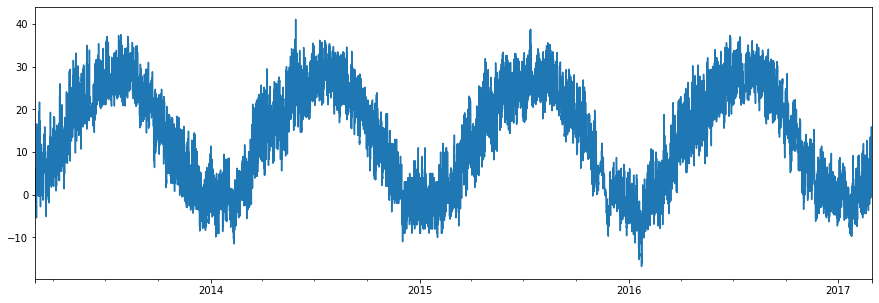

In [10]:
temp = data_clean['TEMP']
plt.figure(figsize=(15,5))
temp.plot()

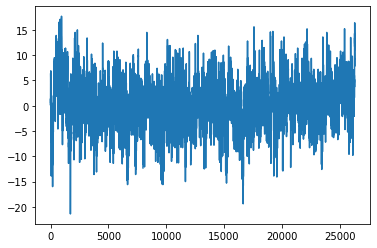

In [11]:
#differencing by a 1 year interval
diff = list()
days_in_year = 365 * 24
for i in range(days_in_year, len(temp)):
    value = temp[i] - temp[i - days_in_year]
    diff.append(value)
plt.plot(diff)
plt.show()

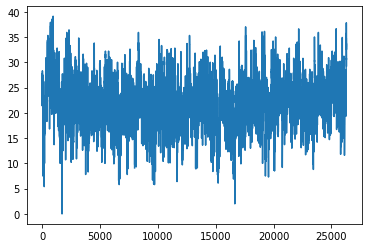

In [12]:
#shifting up for positive values
min_value = min(diff)
values = diff + abs(min_value)
plt.plot(values)

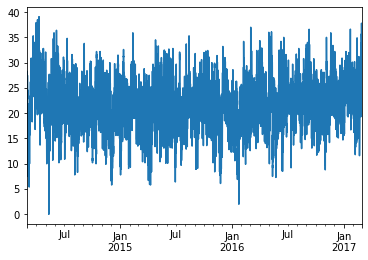

In [13]:
#transforming into time series again
index = pd.to_datetime(data[['year', 'month', 'day', 'hour']])
temperature = pd.Series(values, index[35064-26304:])
temperature.plot()

breakpoint started
subsampler started


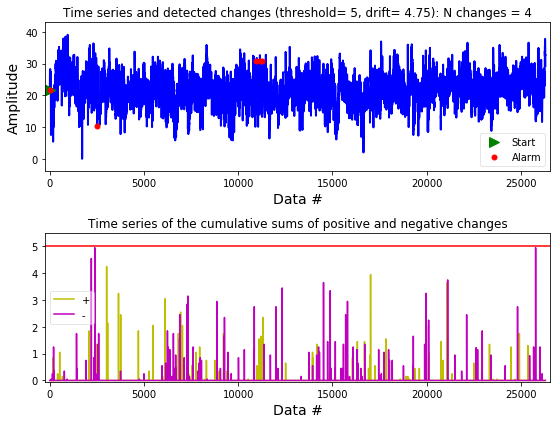

Interval size:  2513
Relative sample size:  11.94 %
----*----
Interval size:  8452
Relative sample size:  4.14 %
----*----
Interval size:  185
Relative sample size:  100%
----*----
Interval size:  123
Relative sample size:  100%
----*----
Interval size:  15031
Relative sample size:  2.0 %
----*----
Done


In [14]:
# Online subsampler

queue = mp.Queue()
return_queue = mp.Queue()
index_queue = mp.Queue()
p1 = mp.Process(target = detection, args = (temperature, queue, 5, 4.75, False, True))
p2 = mp.Process(target = online_subsampler, args = (0.15,0.01,40,50,temperature, queue, return_queue,index_queue, 1000))

p1.start()
p2.start()

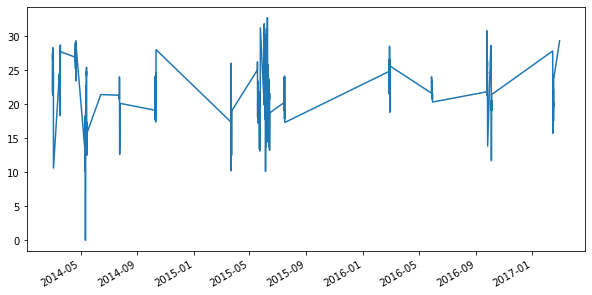

In [15]:
online_subsample = retrieve_data(return_queue)
online_subsample.plot(figsize=(10, 5))

In [ ]:
#Baseline Subsamples
online_subsample_size = len(online_subsample)
uniform_sample, eb_sample = size_optimizer(temperature, online_subsample_size, 40, error = 0.25)

In [18]:
#Comparing subsample sizes
print('Online subsample size: ', online_subsample_size)
print('EB subsample size: ',len(eb_sample))
print('Uniform subsample size: ',len(uniform_sample))

Online subsample size:  2005
EB subsample size:  1912
Uniform subsample size:  2026


In [ ]:
#upscaled subsamples
online_sample_upscaled = online_subsample.resample('T').mean()
eb_sample_upscaled = eb_sample.resample('T').mean()
uniform_sample_upscaled = uniform_sample.resample('T').mean()

In [ ]:
#interpolation querry
#10
print('Interpolation for 57th value: \n')
print('Real value: ', x[57])
print('Empirical Bernstein: ', interpolation_query(eb_sample_upscaled, 57, method = 'linear'))
print('Uniform sampler: ', interpolation_query(uniform_sample_upscaled, 57, method = 'linear'))
print('Online Sampler:', interpolation_query(online_sample_upscaled, 57, method = 'linear'))
print('------------\n')

#17400
print('Interpolation for 17400 value: \n')
print('Real value: ', x[17401])
print('Empirical Bernstein: ', interpolation_query(eb_sample_upscaled, 17401, method = 'linear'))
print('Uniform sampler: ', interpolation_query(uniform_sample_upscaled, 17401, method = 'linear'))
print('Online Sampler:', interpolation_query(online_sample_upscaled, 17401, method = 'linear'))
print('------------\n')

#1003

print('Interpolation for 1003 value: \n')
print('Real value: ', x[1003])
print('Empirical Bernstein: ', interpolation_query(eb_sample_upscaled, 1003, method = 'linear'))
print('Uniform sampler: ', interpolation_query(uniform_sample_upscaled, 1003, method = 'linear'))
print('Online Sampler:', interpolation_query(online_sample_upscaled, 1003, method = 'linear'))
print('------------\n')

#77802

print('Interpolation for 77802 value: \n')
print('Real value: ', x[77802])
print('Empirical Bernstein: ', interpolation_query(eb_sample_upscaled, 77802, method = 'linear'))
print('Uniform sampler: ', interpolation_query(uniform_sample_upscaled, 77802, method = 'linear'))
print('Online Sampler:', interpolation_query(online_sample_upscaled, 77802, method = 'linear'))
print('------------\n')

In [ ]:
# Distance metrics for linear interpolation

print('Euclidean distance: \n')
print('Empirical Bernstein: ', interpolation_distance(z, eb_sample_upscaled))
print('Uniform: ', interpolation_distance(z, uniform_sample_upscaled))
print('Online Sampler: \n', interpolation_distance(z, online_sample_upscaled))
print('------------ \n')

print('DTW distance: \n')
print('Empirical Bernstein: ', interpolation_distance(z, eb_sample_upscaled, distance = 'dtw'))
print('Uniform: ', interpolation_distance(z, uniform_sample_upscaled, distance = 'dtw'))
print('Online Sampler: \n', interpolation_distance(z, online_sample_upscaled, distance = 'dtw'))
print('------------\n')

In [19]:
# Autocorrelation

print('Autocorrelation: \n')
print('Original time series: ')
correlation_query(temperature, number_of_lags = 2, print_lags = True, plot = False)
print('Empirical Bernstein: ')
correlation_query(eb_sample, number_of_lags = 2, print_lags = True, plot = False)
print('Uniform: ' )
correlation_query(uniform_sample, number_of_lags = 2, print_lags = True, plot = False)
print('Online Sampler:', )
correlation_query(online_subsample, number_of_lags = 2, print_lags = True, plot = False)
print('------------ \n')

Autocorrelation: 

Original time series: 
lag 0:  0.9612663263342521
lag 1:  0.9083230102356679
Empirical Bernstein: 
lag 0:  0.02780931730885885
lag 1:  -0.027342757735224685
Uniform: 
lag 0:  0.4780057914049483
lag 1:  0.44746225034322923
Online Sampler:
lag 0:  0.9501300192479761
lag 1:  0.8848239722267375
------------ 



In [20]:
# Distance metrics for autocorrelation

print('Euclidean distance of all autocorrelation lags: \n')
print('Empirical Bernstein: ', correlation_distance(temperature, eb_sample, number_of_lags = 2, print_lags = False, plot = False))
print('Uniform: ', correlation_distance(temperature, uniform_sample, number_of_lags = 2, print_lags = False, plot = False))
print('Online Sampler: \n', correlation_distance(temperature, online_subsample, number_of_lags = 2, print_lags = False, plot = False))
print('------------ \n')

Euclidean distance of all autocorrelation lags: 

Empirical Bernstein:  1.3216703132972283
Uniform:  0.6677824380955169
Online Sampler: 
 0.026004271242720797
------------ 



### RAIN

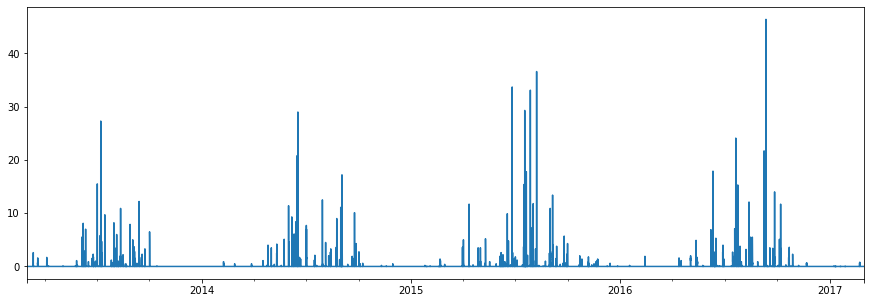

In [22]:
rain = data_clean['RAIN']
plt.figure(figsize=(15,5))
rain.plot()

In [23]:
rain.head()

2013-03-01 00:00:00    0.0
2013-03-01 01:00:00    0.0
2013-03-01 02:00:00    0.0
2013-03-01 03:00:00    0.0
2013-03-01 04:00:00    0.0
Name: RAIN, dtype: float64

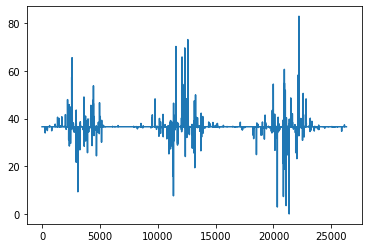

In [27]:
#differencing by a 1 year interval
diff = list()
days_in_year = 365 * 24
for i in range(days_in_year, len(temp)):
    value = rain[i] - rain[i - days_in_year]
    diff.append(value)

#shifting up for positive values
min_value = min(diff)
values = diff + abs(min_value)
plt.plot(values)

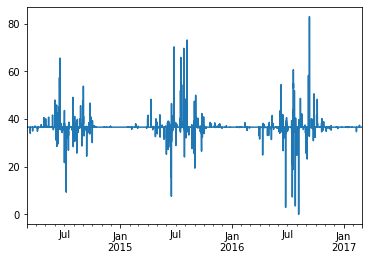

In [28]:
#transforming into time series again
index = pd.to_datetime(data[['year', 'month', 'day', 'hour']])
rain = pd.Series(values, index[35064-26304:])
rain.plot()

breakpoint started
subsampler started


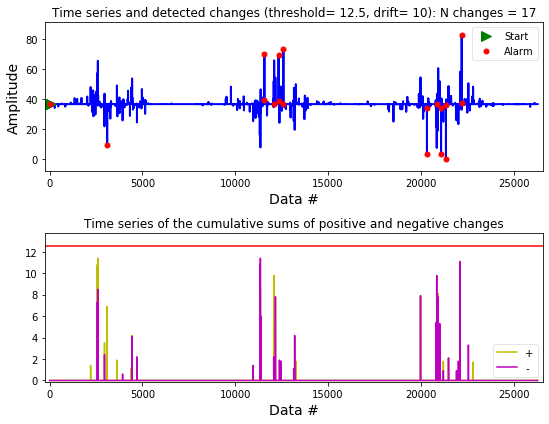

Interval size:  3097
Relative sample size:  8.07 %
----*----
Interval size:  8475
Relative sample size:  2.95 %
----*----
Block size greater than data interval
----*----
Interval size:  526
Relative sample size:  100%
----*----
Interval size:  234
Relative sample size:  100%
----*----
Block size greater than data interval
----*----
Interval size:  262
Relative sample size:  100%
----*----
Block size greater than data interval
----*----
Interval size:  7735
Relative sample size:  3.23 %
----*----
Block size greater than data interval
----*----
Interval size:  526
Relative sample size:  100%
----*----
Interval size:  234
Relative sample size:  100%
----*----
Block size greater than data interval
----*----
Interval size:  262
Relative sample size:  100%
----*----
Block size greater than data interval
----*----
Interval size:  846
Relative sample size:  100%
----*----
Block size greater than data interval
----*----
Interval size:  4100
Relative sample size:  6.1 %
----*----
Done


In [33]:
# Online subsampler

queue = mp.Queue()
return_queue = mp.Queue()
index_queue = mp.Queue()
p1 = mp.Process(target = detection, args = (rain, queue, 12.5, 10, False, True))
p2 = mp.Process(target = online_subsampler, args = (0.15,0.01,80,50,rain, queue, return_queue,index_queue, 1000))

p1.start()
p2.start()

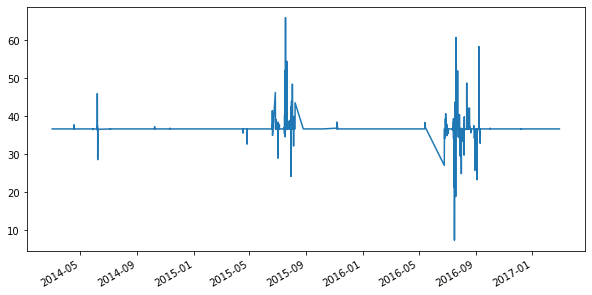

In [34]:
online_subsample = retrieve_data(return_queue)
online_subsample.plot(figsize=(10, 5))

In [36]:
#Baseline Subsamples
online_subsample_size = len(online_subsample)
uniform_sample, eb_sample = size_optimizer(rain, online_subsample_size, 40, error = 0.25)

In [37]:
#Comparing subsample sizes
print('Online subsample size: ', online_subsample_size)
print('EB subsample size: ',len(eb_sample))
print('Uniform subsample size: ',len(uniform_sample))

Online subsample size:  5904
EB subsample size:  2058
Uniform subsample size:  6578


In [38]:
#upscaled subsamples
online_sample_upscaled = online_subsample.resample('T').mean()
eb_sample_upscaled = eb_sample.resample('T').mean()
uniform_sample_upscaled = uniform_sample.resample('T').mean()

In [ ]:
#interpolation querry
#10
print('Interpolation for 57th value: \n')
print('Real value: ', x[57])
print('Empirical Bernstein: ', interpolation_query(eb_sample_upscaled, 57, method = 'linear'))
print('Uniform sampler: ', interpolation_query(uniform_sample_upscaled, 57, method = 'linear'))
print('Online Sampler:', interpolation_query(online_sample_upscaled, 57, method = 'linear'))
print('------------\n')

#17400
print('Interpolation for 17400 value: \n')
print('Real value: ', x[17401])
print('Empirical Bernstein: ', interpolation_query(eb_sample_upscaled, 17401, method = 'linear'))
print('Uniform sampler: ', interpolation_query(uniform_sample_upscaled, 17401, method = 'linear'))
print('Online Sampler:', interpolation_query(online_sample_upscaled, 17401, method = 'linear'))
print('------------\n')

#1003

print('Interpolation for 1003 value: \n')
print('Real value: ', x[1003])
print('Empirical Bernstein: ', interpolation_query(eb_sample_upscaled, 1003, method = 'linear'))
print('Uniform sampler: ', interpolation_query(uniform_sample_upscaled, 1003, method = 'linear'))
print('Online Sampler:', interpolation_query(online_sample_upscaled, 1003, method = 'linear'))
print('------------\n')

#77802

print('Interpolation for 77802 value: \n')
print('Real value: ', x[77802])
print('Empirical Bernstein: ', interpolation_query(eb_sample_upscaled, 77802, method = 'linear'))
print('Uniform sampler: ', interpolation_query(uniform_sample_upscaled, 77802, method = 'linear'))
print('Online Sampler:', interpolation_query(online_sample_upscaled, 77802, method = 'linear'))
print('------------\n')

In [ ]:
# Distance metrics for linear interpolation

print('Euclidean distance: \n')
print('Empirical Bernstein: ', interpolation_distance(z, eb_sample_upscaled))
print('Uniform: ', interpolation_distance(z, uniform_sample_upscaled))
print('Online Sampler: \n', interpolation_distance(z, online_sample_upscaled))
print('------------ \n')

print('DTW distance: \n')
print('Empirical Bernstein: ', interpolation_distance(z, eb_sample_upscaled, distance = 'dtw'))
print('Uniform: ', interpolation_distance(z, uniform_sample_upscaled, distance = 'dtw'))
print('Online Sampler: \n', interpolation_distance(z, online_sample_upscaled, distance = 'dtw'))
print('------------\n')

In [39]:
# Autocorrelation

print('Autocorrelation: \n')
print('Original time series: ')
correlation_query(rain, number_of_lags = 2, print_lags = True, plot = False)
print('Empirical Bernstein: ')
correlation_query(eb_sample, number_of_lags = 2, print_lags = True, plot = False)
print('Uniform: ' )
correlation_query(uniform_sample, number_of_lags = 2, print_lags = True, plot = False)
print('Online Sampler:', )
correlation_query(online_subsample, number_of_lags = 2, print_lags = True, plot = False)
print('------------ \n')

Autocorrelation: 

Original time series: 
lag 0:  0.37420353693493213
lag 1:  0.20716497999244818
Empirical Bernstein: 
lag 0:  0.004378631824826079
lag 1:  -0.021644098634054844
Uniform: 
lag 0:  0.09188426251752699
lag 1:  0.08188155761659904
Online Sampler:
lag 0:  0.4689961025325531
lag 1:  0.3092129773441004
------------ 



In [40]:
# Distance metrics for autocorrelation

print('Euclidean distance of all autocorrelation lags: \n')
print('Empirical Bernstein: ', correlation_distance(rain, eb_sample, number_of_lags = 2, print_lags = False, plot = False))
print('Uniform: ', correlation_distance(rain, uniform_sample, number_of_lags = 2, print_lags = False, plot = False))
print('Online Sampler: \n', correlation_distance(rain, online_subsample, number_of_lags = 2, print_lags = False, plot = False))
print('------------ \n')

Euclidean distance of all autocorrelation lags: 

Empirical Bernstein:  0.43488395567278426
Uniform:  0.30886908008050196
Online Sampler: 
 0.1392818159562191
------------ 



### PRES

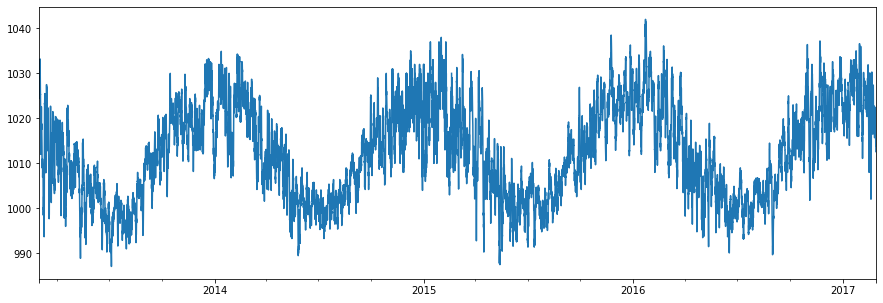

In [9]:
pres = data_clean['PRES']
plt.figure(figsize=(15,5))
pres.plot()

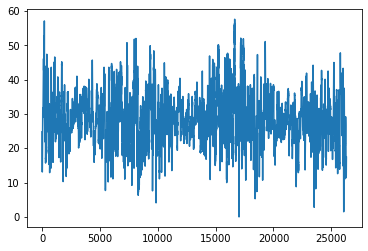

In [10]:
#differencing by a 1 year interval
diff = list()
days_in_year = 365 * 24
for i in range(days_in_year, len(pres)):
    value = pres[i] - pres[i - days_in_year]
    diff.append(value)

#shifting up for positive values
min_value = min(diff)
values = diff + abs(min_value)
plt.plot(values)

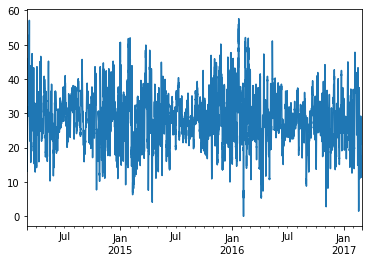

In [11]:
#transforming into time series again
index = pd.to_datetime(data[['year', 'month', 'day', 'hour']])
pres = pd.Series(values, index[35064-26304:])
pres.plot()

breakpoint started
subsampler started


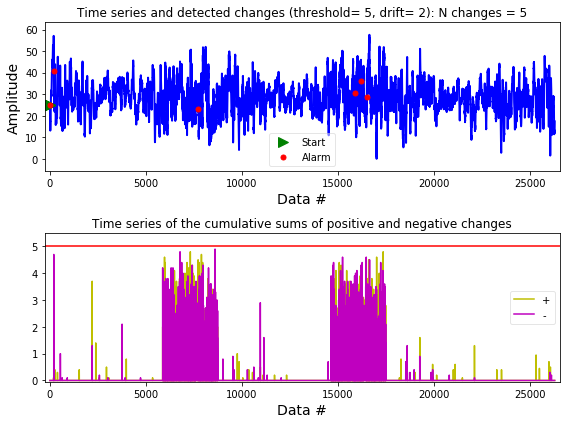

Interval size:  205
Relative sample size:  73.17 %
----*----
Interval size:  7539
Relative sample size:  3.98 %
----*----
Interval size:  8164
Relative sample size:  3.67 %
----*----
Interval size:  306
Relative sample size:  100%
----*----
Interval size:  290
Relative sample size:  100%
----*----
Interval size:  9800
Relative sample size:  3.06 %
----*----
Done


In [16]:
# Online subsampler

queue = mp.Queue()
return_queue = mp.Queue()
index_queue = mp.Queue()
p1 = mp.Process(target = detection, args = (pres, queue, 5, 2, False, True))
p2 = mp.Process(target = online_subsampler, args = (0.15,0.01,55,50,pres, queue, return_queue,index_queue, 1000))

p1.start()
p2.start()

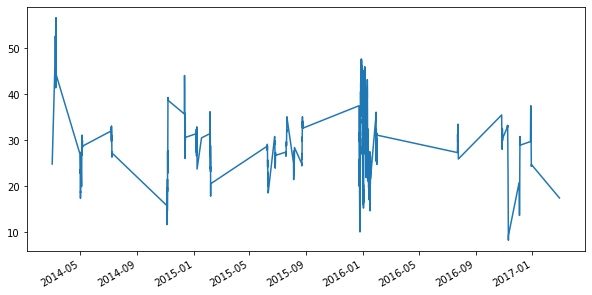

In [17]:
online_subsample = retrieve_data(return_queue)
online_subsample.plot(figsize=(10, 5))

In [18]:
#Baseline Subsamples
online_subsample_size = len(online_subsample)
uniform_sample, eb_sample = size_optimizer(pres, online_subsample_size, 40, error = 0.25)

In [20]:
#Comparing subsample sizes
print('Online subsample size: ', online_subsample_size)
print('EB subsample size: ',len(eb_sample))
print('Uniform subsample size: ',len(uniform_sample))

Online subsample size:  2770
EB subsample size:  3363
Uniform subsample size:  2925


In [ ]:
#upscaled subsamples
online_sample_upscaled = online_subsample.resample('T').mean()
eb_sample_upscaled = eb_sample.resample('T').mean()
uniform_sample_upscaled = uniform_sample.resample('T').mean()

In [ ]:
#interpolation querry
#10
print('Interpolation for 57th value: \n')
print('Real value: ', x[57])
print('Empirical Bernstein: ', interpolation_query(eb_sample_upscaled, 57, method = 'linear'))
print('Uniform sampler: ', interpolation_query(uniform_sample_upscaled, 57, method = 'linear'))
print('Online Sampler:', interpolation_query(online_sample_upscaled, 57, method = 'linear'))
print('------------\n')

#17400
print('Interpolation for 17400 value: \n')
print('Real value: ', x[17401])
print('Empirical Bernstein: ', interpolation_query(eb_sample_upscaled, 17401, method = 'linear'))
print('Uniform sampler: ', interpolation_query(uniform_sample_upscaled, 17401, method = 'linear'))
print('Online Sampler:', interpolation_query(online_sample_upscaled, 17401, method = 'linear'))
print('------------\n')

#1003

print('Interpolation for 1003 value: \n')
print('Real value: ', x[1003])
print('Empirical Bernstein: ', interpolation_query(eb_sample_upscaled, 1003, method = 'linear'))
print('Uniform sampler: ', interpolation_query(uniform_sample_upscaled, 1003, method = 'linear'))
print('Online Sampler:', interpolation_query(online_sample_upscaled, 1003, method = 'linear'))
print('------------\n')

#77802

print('Interpolation for 77802 value: \n')
print('Real value: ', x[77802])
print('Empirical Bernstein: ', interpolation_query(eb_sample_upscaled, 77802, method = 'linear'))
print('Uniform sampler: ', interpolation_query(uniform_sample_upscaled, 77802, method = 'linear'))
print('Online Sampler:', interpolation_query(online_sample_upscaled, 77802, method = 'linear'))
print('------------\n')

In [ ]:
# Distance metrics for linear interpolation

print('Euclidean distance: \n')
print('Empirical Bernstein: ', interpolation_distance(z, eb_sample_upscaled))
print('Uniform: ', interpolation_distance(z, uniform_sample_upscaled))
print('Online Sampler: \n', interpolation_distance(z, online_sample_upscaled))
print('------------ \n')

print('DTW distance: \n')
print('Empirical Bernstein: ', interpolation_distance(z, eb_sample_upscaled, distance = 'dtw'))
print('Uniform: ', interpolation_distance(z, uniform_sample_upscaled, distance = 'dtw'))
print('Online Sampler: \n', interpolation_distance(z, online_sample_upscaled, distance = 'dtw'))
print('------------\n')

In [21]:
# Autocorrelation

print('Autocorrelation: \n')
print('Original time series: ')
correlation_query(pres, number_of_lags = 2, print_lags = True, plot = False)
print('Empirical Bernstein: ')
correlation_query(eb_sample, number_of_lags = 2, print_lags = True, plot = False)
print('Uniform: ' )
correlation_query(uniform_sample, number_of_lags = 2, print_lags = True, plot = False)
print('Online Sampler:', )
correlation_query(online_subsample, number_of_lags = 2, print_lags = True, plot = False)
print('------------ \n')

Autocorrelation: 

Original time series: 
lag 0:  0.9852164800200182
lag 1:  0.9782923283800294
Empirical Bernstein: 
lag 0:  0.026106476769266408
lag 1:  -0.015577710380925406
Uniform: 
lag 0:  0.8716153090375369
lag 1:  0.6551969985970861
Online Sampler:
lag 0:  0.9634632356264919
lag 1:  0.9430216044167252
------------ 



In [22]:
# Distance metrics for autocorrelation

print('Euclidean distance of all autocorrelation lags: \n')
print('Empirical Bernstein: ', correlation_distance(pres, eb_sample, number_of_lags = 2, print_lags = False, plot = False))
print('Uniform: ', correlation_distance(pres, uniform_sample, number_of_lags = 2, print_lags = False, plot = False))
print('Online Sampler: \n', correlation_distance(pres, online_subsample, number_of_lags = 2, print_lags = False, plot = False))
print('------------ \n')

Euclidean distance of all autocorrelation lags: 

Empirical Bernstein:  1.3811841485777192
Uniform:  0.3424847707214729
Online Sampler: 
 0.041439445104152664
------------ 



### PM2.5

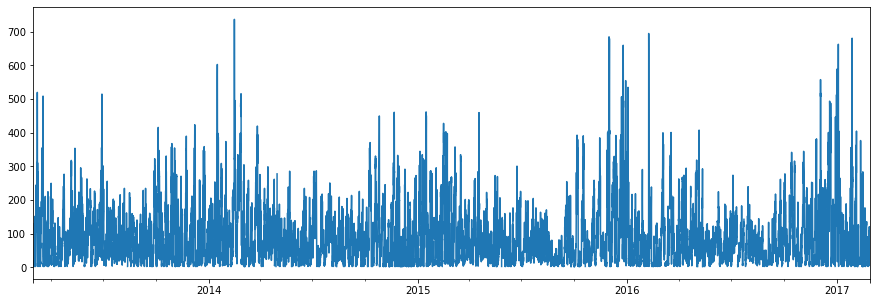

In [12]:
pm_25 = data_clean['PM2.5']
plt.figure(figsize=(15,5))
pm_25.plot()

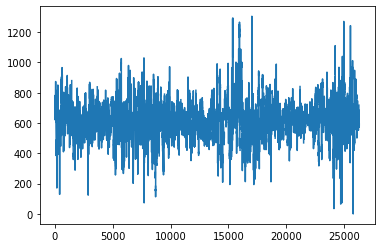

In [13]:
#differencing by a 1 year interval
diff = list()
days_in_year = 365 * 24
for i in range(days_in_year, len(pm_25)):
    value = pm_25[i] - pm_25[i - days_in_year]
    diff.append(value)

#shifting up for positive values
min_value = min(diff)
values = diff + abs(min_value)
plt.plot(values)

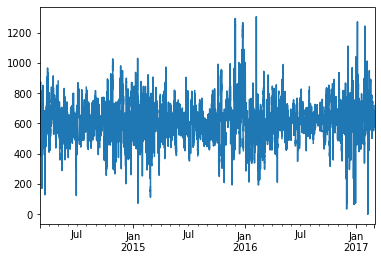

In [14]:
#transforming into time series again
index = pd.to_datetime(data[['year', 'month', 'day', 'hour']])
pm_25 = pd.Series(values, index[35064-26304:])
pm_25.plot()

In [15]:
# Online subsampler

queue = mp.Queue()
return_queue = mp.Queue()
index_queue = mp.Queue()
p1 = mp.Process(target = detection, args = (pm_25, queue, 250, 75, False, True))
p2 = mp.Process(target = online_subsampler, args = (0.15,0.01,1100,50,pm_25, queue, return_queue,index_queue, 1000))

p1.start()
p2.start()

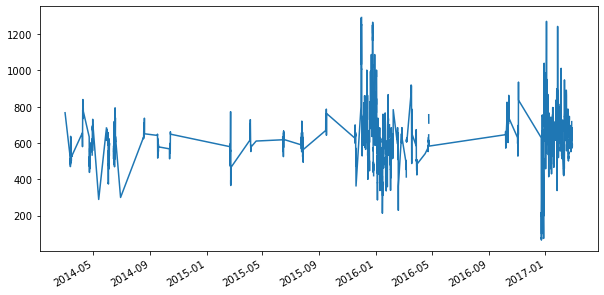

In [16]:
online_subsample = retrieve_data(return_queue)
online_subsample.plot(figsize=(10, 5))

In [17]:
#Baseline Subsamples
online_subsample_size = len(online_subsample)
uniform_sample, eb_sample = size_optimizer(pm_25, online_subsample_size, 1100, error = 0.25)

In [18]:
#Comparing subsample sizes
print('Online subsample size: ', online_subsample_size)
print('EB subsample size: ',len(eb_sample))
print('Uniform subsample size: ',len(uniform_sample))

Online subsample size:  8542
EB subsample size:  6949
Uniform subsample size:  8770


In [19]:
#upscaled subsamples
online_sample_upscaled = online_subsample.resample('T').mean()
eb_sample_upscaled = eb_sample.resample('T').mean()
uniform_sample_upscaled = uniform_sample.resample('T').mean()

In [ ]:
#interpolation querry
#10
print('Interpolation for 57th value: \n')
print('Real value: ', x[57])
print('Empirical Bernstein: ', interpolation_query(eb_sample_upscaled, 57, method = 'linear'))
print('Uniform sampler: ', interpolation_query(uniform_sample_upscaled, 57, method = 'linear'))
print('Online Sampler:', interpolation_query(online_sample_upscaled, 57, method = 'linear'))
print('------------\n')

#17400
print('Interpolation for 17400 value: \n')
print('Real value: ', x[17401])
print('Empirical Bernstein: ', interpolation_query(eb_sample_upscaled, 17401, method = 'linear'))
print('Uniform sampler: ', interpolation_query(uniform_sample_upscaled, 17401, method = 'linear'))
print('Online Sampler:', interpolation_query(online_sample_upscaled, 17401, method = 'linear'))
print('------------\n')

#1003

print('Interpolation for 1003 value: \n')
print('Real value: ', x[1003])
print('Empirical Bernstein: ', interpolation_query(eb_sample_upscaled, 1003, method = 'linear'))
print('Uniform sampler: ', interpolation_query(uniform_sample_upscaled, 1003, method = 'linear'))
print('Online Sampler:', interpolation_query(online_sample_upscaled, 1003, method = 'linear'))
print('------------\n')

#77802

print('Interpolation for 77802 value: \n')
print('Real value: ', x[77802])
print('Empirical Bernstein: ', interpolation_query(eb_sample_upscaled, 77802, method = 'linear'))
print('Uniform sampler: ', interpolation_query(uniform_sample_upscaled, 77802, method = 'linear'))
print('Online Sampler:', interpolation_query(online_sample_upscaled, 77802, method = 'linear'))
print('------------\n')

In [ ]:
# Distance metrics for linear interpolation

print('Euclidean distance: \n')
print('Empirical Bernstein: ', interpolation_distance(z, eb_sample_upscaled))
print('Uniform: ', interpolation_distance(z, uniform_sample_upscaled))
print('Online Sampler: \n', interpolation_distance(z, online_sample_upscaled))
print('------------ \n')

print('DTW distance: \n')
print('Empirical Bernstein: ', interpolation_distance(z, eb_sample_upscaled, distance = 'dtw'))
print('Uniform: ', interpolation_distance(z, uniform_sample_upscaled, distance = 'dtw'))
print('Online Sampler: \n', interpolation_distance(z, online_sample_upscaled, distance = 'dtw'))
print('------------\n')

In [20]:
# Autocorrelation

print('Autocorrelation: \n')
print('Original time series: ')
correlation_query(pm_25, number_of_lags = 6, print_lags = True, plot = False)
print('Empirical Bernstein: ')
correlation_query(eb_sample, number_of_lags = 6, print_lags = True, plot = False)
print('Uniform: ' )
correlation_query(uniform_sample, number_of_lags = 6, print_lags = True, plot = False)
print('Online Sampler:', )
correlation_query(online_subsample, number_of_lags = 6, print_lags = True, plot = False)
print('------------ \n')

Autocorrelation: 

Original time series: 
lag 0:  0.9695875910591533
lag 1:  0.9250434141790735
lag 2:  0.8817674338809707
lag 3:  0.8404936342422941
lag 4:  0.801645082805846
lag 5:  0.7639918255347905
Empirical Bernstein: 
lag 0:  -0.010657329923200875
lag 1:  0.003508917027850029
lag 2:  0.0066228019743818835
lag 3:  0.01129434398456526
lag 4:  -0.0033209237308528695
lag 5:  -3.0789772990058965e-05
Uniform: 
lag 0:  0.8811637787294245
lag 1:  0.7645466903376551
lag 2:  0.6728638162353534
lag 3:  0.5999334245316902
lag 4:  0.5316327351054424
lag 5:  0.47648056931821686
Online Sampler:
lag 0:  0.9559194569418733
lag 1:  0.9097030789793661
lag 2:  0.8643301992821064
lag 3:  0.821031125215244
lag 4:  0.7787170038895793
lag 5:  0.7385873579861357
------------ 



In [21]:
n_lags = 6
correlation_real = [correlation_query(pm_25, lags) for lags in range(1,n_lags)]
correlation_eb = [correlation_query(eb_sample, lags) for lags in range(1,n_lags)]
correlation_uniform = [correlation_query(uniform_sample, lags) for lags in range(1,n_lags)]
correlation_online = [correlation_query(online_subsample, lags) for lags in range(1,n_lags)]

In [22]:
correlation_online[-1]

[0.9559194569418733,
 0.9097030789793661,
 0.8643301992821064,
 0.821031125215244,
 0.7787170038895793]

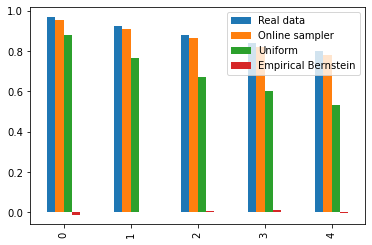

In [23]:
correlation = pd.DataFrame({'Real data' : correlation_real[-1],'Empirical Bernstein': correlation_eb[-1],'Uniform': correlation_uniform[-1],'Online sampler': correlation_online[-1]})
correlation.plot(y = ['Real data','Online sampler', 'Uniform', 'Empirical Bernstein'], kind = 'bar')

In [24]:
# Distance metrics for autocorrelation

print('Euclidean distance of all autocorrelation lags: \n')
print('Empirical Bernstein: ', correlation_distance(pm_25, eb_sample, number_of_lags = 2, print_lags = False, plot = False))
print('Uniform: ', correlation_distance(pm_25, uniform_sample, number_of_lags = 2, print_lags = False, plot = False))
print('Online Sampler: \n', correlation_distance(pm_25, online_subsample, number_of_lags = 2, print_lags = False, plot = False))
print('------------ \n')

Euclidean distance of all autocorrelation lags: 

Empirical Bernstein:  1.345401774397321
Uniform:  0.1832429233306204
Online Sampler: 
 0.020546137697565837
------------ 



In [25]:
n_lags = 11
euclidean_distance_eb = [correlation_distance(pm_25, eb_sample, lags) for lags in range(1,n_lags)]
euclidean_distance_uniform = [correlation_distance(pm_25, uniform_sample, lags) for lags in range(1,n_lags)]
euclidean_distance_online = [correlation_distance(pm_25, online_subsample, lags) for lags in range(1,n_lags)]

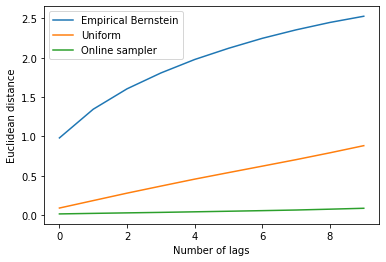

In [26]:
plt.plot(euclidean_distance_eb, label = 'Empirical Bernstein')
plt.plot(euclidean_distance_uniform, label = 'Uniform')
plt.plot(euclidean_distance_online, label = 'Online sampler')
plt.xlabel('Number of lags')
plt.ylabel('Euclidean distance')
plt.legend()
plt.show()

In [31]:
online_subsample_fft = online_subsample - online_subsample.mean()

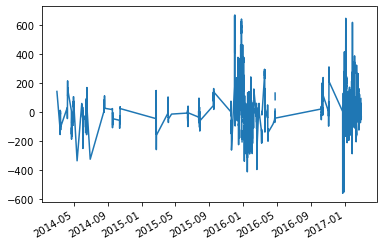

In [32]:
online_subsample_fft.plot()

In [33]:
online_subsample_fft

2014-03-01 00:00:00    143.284429
2014-03-12 21:00:00   -102.715571
2014-03-12 22:00:00    -89.715571
2014-03-12 23:00:00    -48.715571
2014-03-13 00:00:00     -2.715571
                          ...    
2017-02-28 19:00:00    -42.715571
2017-02-28 20:00:00    -45.715571
2017-02-28 21:00:00    -44.715571
2017-02-28 22:00:00    -40.715571
2017-02-28 23:00:00    -31.715571
Length: 8542, dtype: float64

In [34]:
online_sample_upscaled = online_subsample_fft.resample('T').mean()

In [35]:
online_sample_upscaled = online_sample_upscaled.fillna(0)

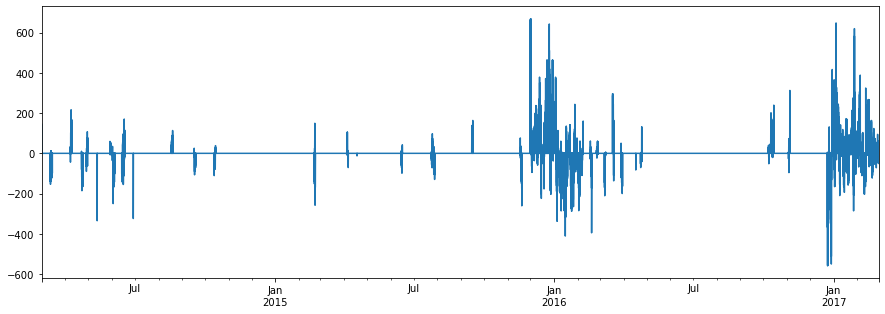

In [36]:
plt.figure(figsize=(15,5))
online_sample_upscaled.plot()

In [37]:
online_subsample_frequency = np.fft.fft(online_sample_upscaled, norm = "ortho")

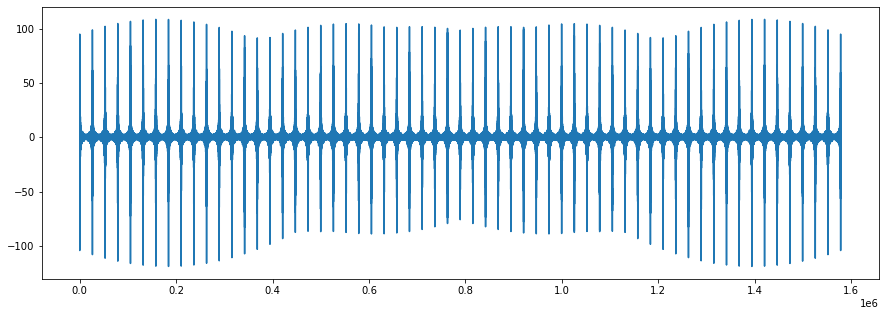

In [38]:
plt.figure(figsize=(15,5))
plt.plot(online_subsample_frequency)

In [39]:
pm_25_normalized = pm_25 - pm_25.mean()
eb_subsample_fft = eb_sample - eb_sample.mean()
uniform_subsample_fft = uniform_sample - uniform_sample.mean()

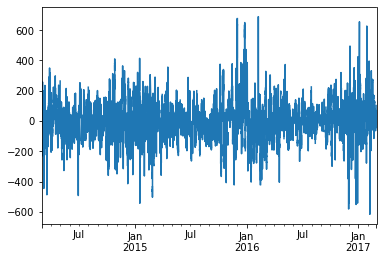

In [40]:
pm_25_normalized.plot()

In [41]:
#upscaled subsamples
pm_25_upscaled = pm_25_normalized.resample('T').mean()
eb_sample_upscaled = eb_subsample_fft.resample('T').mean()
uniform_sample_upscaled = uniform_subsample_fft.resample('T').mean()

In [42]:
eb_sample_upscaled = eb_sample_upscaled.fillna(0)
uniform_sample_upscaled = uniform_sample_upscaled.fillna(0)
pm_25_upscaled = pm_25_upscaled.fillna(0)

In [43]:
pm_frequency = np.fft.fft(pm_25_upscaled, norm = "ortho")
eb_subsample_frequency = np.fft.fft(eb_sample_upscaled, norm = 'ortho')
uniform_subsample_frequency = np.fft.fft(uniform_sample_upscaled, norm = 'ortho')

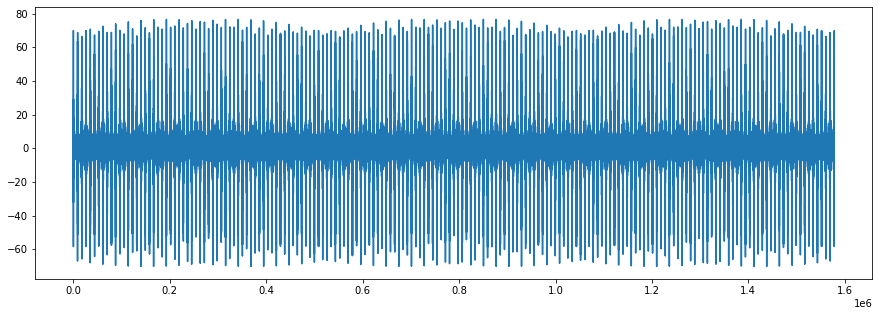

In [44]:
plt.figure(figsize=(15,5))
plt.plot(uniform_subsample_frequency)

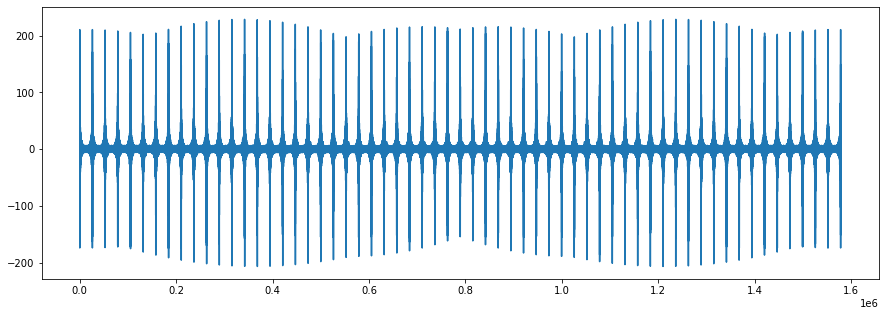

In [45]:
plt.figure(figsize=(15,5))
plt.plot(pm_frequency)

In [47]:
#dividing be the max value in each
online_subsample_frequency = np.fft.fft(online_sample_upscaled)
online_subsample_frequency = online_subsample_frequency/max(online_subsample_frequency)
pm_frequency = np.fft.fft(pm_25_upscaled)
pm_frequency = pm_frequency/max(pm_frequency)
eb_subsample_frequency = np.fft.fft(eb_sample_upscaled)
eb_subsample_frequency = eb_subsample_frequency/max(eb_subsample_frequency)
uniform_subsample_frequency = np.fft.fft(uniform_sample_upscaled)
uniform_subsample_frequency = uniform_subsample_frequency/max(uniform_subsample_frequency)

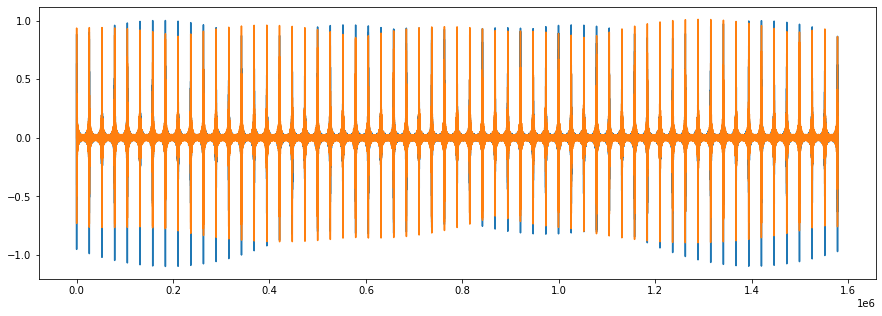

In [50]:
plt.figure(figsize=(15,5))
plt.plot(online_subsample_frequency)
plt.plot(pm_frequency)
#plt.plot(eb_subsample_frequency)
#plt.plot(uniform_subsample_frequency)
plt.show()

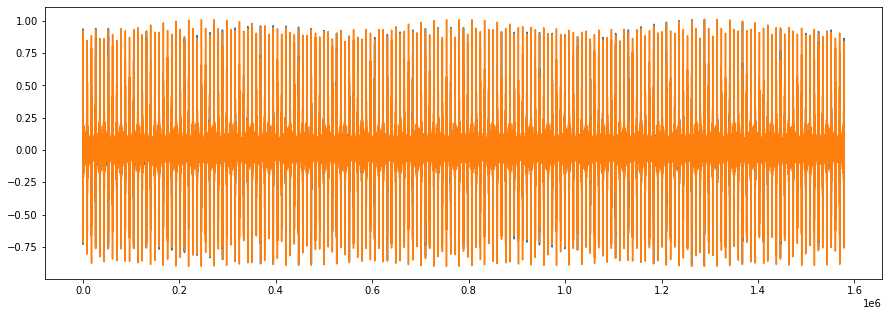

In [51]:
plt.figure(figsize=(15,5))
#plt.plot(online_subsample_frequency)
plt.plot(pm_frequency)
#plt.plot(eb_subsample_frequency)
plt.plot(uniform_subsample_frequency)
plt.show()

In [61]:
#indicator version
indicator_uniform = [1 if x != 0 else 0 for x in uniform_sample_upscaled]
indicator_eb = [1 if x != 0 else 0 for x in eb_sample_upscaled]
indicator_online = [1 if x != 0 else 0 for x in online_sample_upscaled]
indicator_real = [1 if x != 0 else 0 for x in pm_25_upscaled]

In [62]:
# fft indicator version
fft_indicator_uniform = np.fft.fft(indicator_uniform)
fft_indicator_eb = np.fft.fft(indicator_eb)
fft_indicator_online = np.fft.fft(indicator_online)
fft_indicator_real = np.fft.fft(indicator_real)

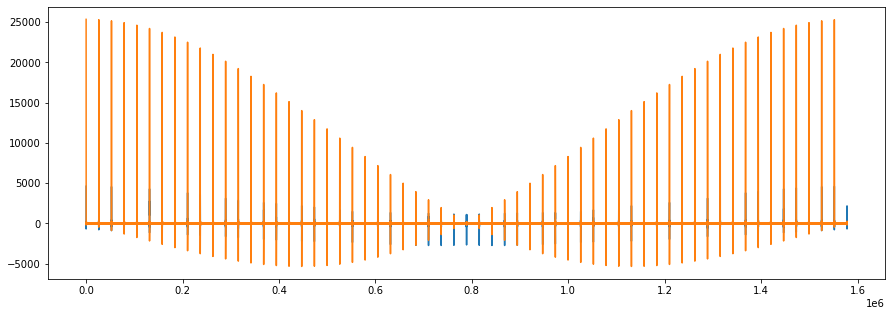

In [63]:
plt.figure(figsize=(15,5))
plt.plot(fft_indicator_online)
plt.plot(fft_indicator_real)
plt.show()

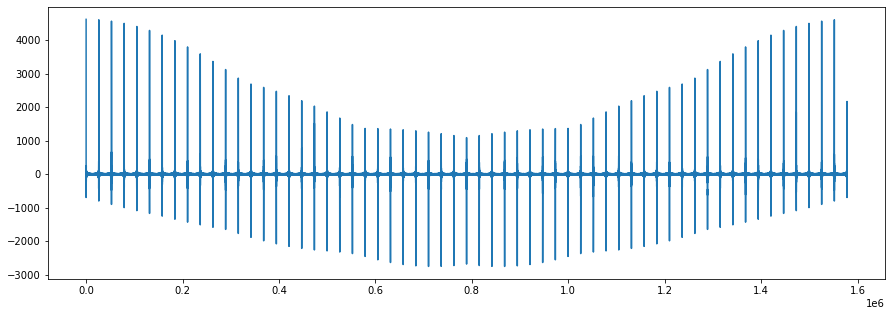

In [67]:
plt.figure(figsize=(15,5))
plt.plot(fft_indicator_online)
#plt.plot(fft_indicator_real)
plt.show()